### Data Generation (Random)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

num_timestamps = 50
# Generate 10 timestamps starting from now, spaced 1 hour apart
timestamps = [datetime.now() + timedelta(hours=i) for i in range(num_timestamps)]

# Generate random data for features
np.random.seed(42)  # For reproducibility
data = {
    "timestamp": timestamps,
    "feature_part1": np.random.rand(num_timestamps),
    "feature_part2": np.random.rand(num_timestamps),
    "feature_part3": np.random.rand(num_timestamps),
    "additional_feature1": np.random.rand(num_timestamps),
    "additional_feature2": np.random.rand(num_timestamps),
    "demand": np.random.randint(50, 200, size=num_timestamps)
}

# Create DataFrame
sample_df = pd.DataFrame(data)
print(sample_df)

In [ ]:
# Set timestamp as the index
sample_df.set_index("timestamp", inplace=True)

# Prepare endogenous (dependent) variable (combine features and demand)
endog = sample_df[["feature_part1", "feature_part2", "feature_part3", "demand"]]

# Prepare exogenous (independent) variables
exog = sample_df[["additional_feature1", "additional_feature2"]]

In [ ]:
# Train-test split (70% train, 30% test)
train_size = int(len(sample_df) * 0.7)
train_endog = endog.iloc[:train_size]
test_endog = endog.iloc[train_size:]

train_exog = exog.iloc[:train_size]
test_exog = exog.iloc[train_size:]

In [ ]:
# Fit the SARIMAX model on the training set
model = SARIMAX(train_endog["demand"], exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))  # No seasonality
results = model.fit()

# Print model summary
print(results.summary())

In [ ]:
# Validate on the test set
predictions = results.predict(start=train_size, end=len(sample_df) - 1, exog=test_exog)
test_demand = test_endog["demand"]

In [ ]:
# Evaluate performance: MSE, MAPE, and Accuracy
mse = mean_squared_error(test_demand, predictions)
mape = np.mean(np.abs((test_demand - predictions) / test_demand)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Model accuracy

print(f"\nMean Squared Error (MSE) on Test Set: {mse}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.2f}%")
print(f"Model Accuracy on Test Set: {accuracy:.2f}%")

In [ ]:
# Forecast the next 5 timestamps
forecast_steps = 5
future_exog = np.random.rand(forecast_steps, 2)  # Generate future exogenous data
forecast = results.get_forecast(steps=forecast_steps, exog=future_exog)

# Extract predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [ ]:
# Plot observed, predictions, and forecasted data
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(train_endog.index, train_endog["demand"], label="Training Data", marker="o")

# Plot test data
plt.plot(test_endog.index, test_endog["demand"], label="Test Data", marker="o", color="orange")

# Plot predictions
plt.plot(test_endog.index, predictions, label="Predictions", marker="x", color="green")

# Plot forecast
forecast_index = [test_endog.index[-1] + timedelta(hours=i+1) for i in range(forecast_steps)]
plt.plot(forecast_index, forecast_mean, label="Forecast", marker="x", color="red")

In [ ]:
# Add confidence intervals for forecast
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="red",
    alpha=0.3,
    label="Confidence Interval"
)

plt.title("SARIMAX Demand Forecast with Validation")
plt.xlabel("Timestamp")
plt.ylabel("Demand")
plt.legend()
plt.grid()
plt.show()

### ELECTRICITY Transformer Dataset (benchmark)

In [ ]:
df = pd.read_csv('./ETTh1.csv/ETTh1.csv')
print(df.columns)

In [ ]:
print(df)

In [ ]:
# Set timestamp as the index
df.set_index("date", inplace=True)

# Prepare endogenous (dependent) variable (combine features and demand)
endog = df[["HUFL", "HULL", "MULL","MUFL","OT"]]

# Prepare exogenous (independent) variables
exog = df[["LULL", "LUFL"]]

In [ ]:
# Train-test split (70% train, 30% test)
train_size = int(len(sample_df) * 0.7)
train_endog = endog.iloc[:train_size]
test_endog = endog.iloc[train_size:]

train_exog = exog.iloc[:train_size]
test_exog = exog.iloc[train_size:]

In [ ]:
# Fit the SARIMAX model on the training set
model = SARIMAX(train_endog["OT"], exog=train_exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))  # No seasonality
results = model.fit()

# Print model summary
print(results.summary())

In [ ]:
# Validate on the test set
predictions = results.predict(start=train_size, end=len(df) - 1, exog=test_exog)
test_demand = test_endog["OT"]

In [ ]:
predictions

In [ ]:
len(predictions)

In [ ]:
# Evaluate performance: MSE, MAPE, and Accuracy
mse = mean_squared_error(test_demand, predictions)
for i in range(len(predictions)):
    mape = np.mean(np.abs((test_demand[i] - predictions[i]) / test_demand[i])) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Model accuracy

print(f"\nMean Squared Error (MSE) on Test Set: {mse}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.2f}%")
print(f"Model Accuracy on Test Set: {accuracy:.2f}%")

In [ ]:
# Plot observed, predictions, and forecasted data
plt.figure(figsize=(12, 8))

# Plot training data
plt.plot(train_endog.index, train_endog["OT"], label="Training Data", marker="o")

# Plot test data
plt.plot(test_endog.index, test_endog["OT"], label="Test Data", marker="o", color="orange")

# Plot predictions
plt.plot(test_endog.index, predictions, label="Predictions", marker="x", color="green")


## MD5 Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import prophet
# from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

c:\Users\khars\Desktop\HeteroGNN\heterogpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [3]:
calendar = pd.read_csv('calendar.csv')
selling_prices = pd.read_csv('sell_prices.csv')
sample_submission = pd.read_csv('sample_submission.csv')
sales_train_val = pd.read_csv('sales_train_validation.csv')
sales_train_eval = pd.read_csv('sales_train_evaluation.csv')

In [4]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[66]].set_index('id')[d_cols]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[25]].set_index('id')[d_cols]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1.values[0])), y=x_1.values[0], showlegend=False,
                    mode='lines', name=x_1.index[0],
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2.values[0])), y=x_2.values[0], showlegend=False,
                    mode='lines', name=x_2.index[0],
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3.values[0])), y=x_3.values[0], showlegend=False,
                    mode='lines', name=x_3.index[0],
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()


In [6]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols]
 
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(0, 365), y=x.values[0][0:365], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(365, 730), y=x.values[0][365:730], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(730, 1095), y=x.values[0][730:1095], showlegend=False,
                    mode='lines', name=x.index[0],
                         marker=dict(color="mediumseagreen")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales for id:2")
fig.show()


In [7]:
past_sales = sales_train_val.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = selling_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

In [8]:
def event_count(row):
    if pd.notnull(row['event_name_1']) and pd.notnull(row['event_name_2']):
        return 2
    if pd.notnull(row['event_name_1']):
        return 1

event_calendar = calendar[(calendar.event_name_1.notnull())]
event_calendar['event_count'] = event_calendar.apply(event_count, axis=1)
# event_calendar[['d', 'event_count']]
event_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,event_count
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0,1
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,2016-05-08,11615,Sunday,2,5,2016,d_1927,Mother's day,Cultural,NaN,NaN,1,0,1,1
1948,2016-05-30,11618,Monday,3,5,2016,d_1949,MemorialDay,National,NaN,NaN,0,0,0,1
1951,2016-06-02,11618,Thursday,6,6,2016,d_1952,NBAFinalsStart,Sporting,NaN,NaN,1,0,1,1
1956,2016-06-07,11619,Tuesday,4,6,2016,d_1957,Ramadan starts,Religious,NaN,NaN,1,1,0,1


In [9]:
df = pd.merge(selling_prices, event_calendar[['event_name_1', 'event_type_1', 'wm_yr_wk']], how='left', on='wm_yr_wk')
df.groupby(['store_id','item_id','wm_yr_wk']).count()
# df

sell_price  event_name_1  event_type_1
store_id item_id         wm_yr_wk                                        
CA_1     FOODS_1_001     11101              1             0             0
                         11102              1             1             1
                         11103              1             1             1
                         11104              1             1             1
                         11105              1             0             0
...                                       ...           ...           ...
WI_3     HOUSEHOLD_2_516 11617              1             0             0
                         11618              2             2             2
                         11619              1             1             1
                         11620              1             0             0
                         11621              1             1             1

[6841121 rows x 3 columns]

## Data preprocess

In [10]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:  # Use 'object' directly instead of 'np.object'
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [11]:
def load_and_preprocess_data(sales_file, calendar_file):
    # Load data
    df = pd.read_csv(sales_file)
    calendar = pd.read_csv(calendar_file)
    
    # Downcast data types
    df = downcast(df)
    calendar = downcast(calendar)
    
    # Preprocess sales data
    df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], inplace=True)
    
    # Transpose and set column names
    data = df.set_index('id').T
    data.index = pd.to_datetime(calendar['date'][:len(data)])  # Set datetime index
    data.index.freq = 'D'  # Set frequency to daily
    
    # Handle missing values (fill with 0 or use forward fill)
    data.fillna(0, inplace=True)

    # Select the product with the highest total sales
    total_sales = data.sum()  # Sum across rows to get total sales per product
    max_sales_product = total_sales.idxmax()
    
    # Add lag features
    for lag in range(1, 8):  # Adding 1 to 7 days lag features
        data[f'lag_{lag}'] = data[max_sales_product].shift(lag)

    # Rolling mean (e.g., 7-day rolling mean)
    data['rolling_mean_7'] = data[max_sales_product].rolling(window=7).mean()

    # Remove rows with NaN values after feature engineering
    data.dropna(inplace=True)

    # Normalize values using Min-Max scaling
    scaler = MinMaxScaler()
    data[max_sales_product] = scaler.fit_transform(data[[max_sales_product]])

    # Optionally normalize lag features and rolling mean if needed
    for lag in range(1, 8):
        data[f'lag_{lag}'] = scaler.fit_transform(data[[f'lag_{lag}']])
    
    data['rolling_mean_7'] = scaler.fit_transform(data[['rolling_mean_7']])

    return data, max_sales_product, calendar  # Return entire data and the name of the max sales product



data, max_sales_product, calendar = load_and_preprocess_data(
    'sales_train_evaluation.csv',
    'calendar.csv'
)

## SARIMAX

SARIMAX training completed in: 6.94 minutes
SARIMAX RMSE: 0.05


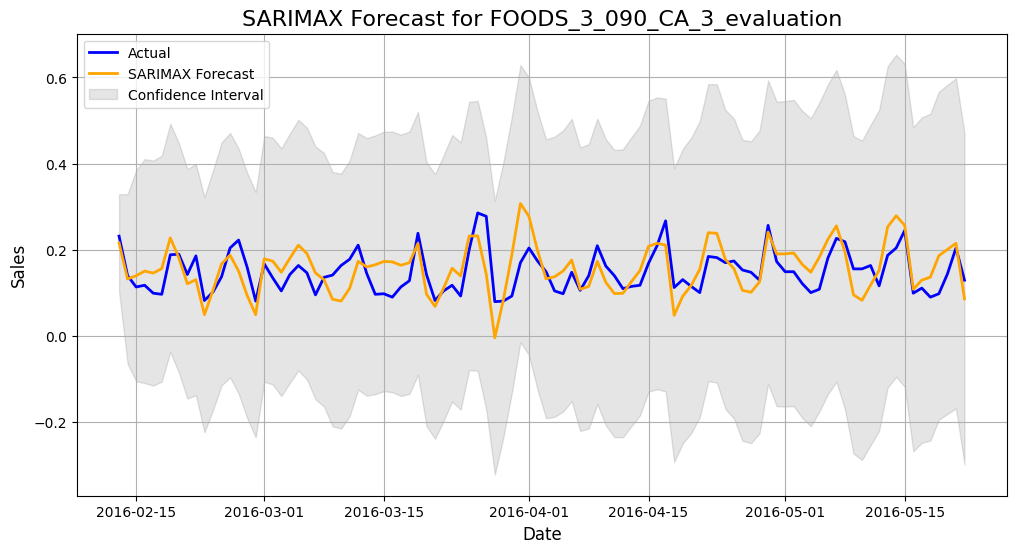

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the specific product data
sales_data = data[max_sales_product]

# Split into training and test sets
train_sarima = sales_data[:-100]  # Training data (all but last 100)
test_sarima = sales_data[-100:]    # Test data (last 100)

# Prepare exogenous features
exog_train = data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']][:-100]
exog_test = data[['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7']][-100:]

# Fit the SARIMAX model
start_time = time.time()
sarimax_model = SARIMAX(train_sarima, 
                         order=(2, 1, 1), 
                         seasonal_order=(2, 1, 1, 42), 
                         exog=exog_train)
sarimax_fit = sarimax_model.fit()
duration = (time.time() - start_time) / 60
print(f'SARIMAX training completed in: {duration:.2f} minutes')

# Forecast using the fitted model
sarimax_forecast = sarimax_fit.get_forecast(steps=100, exog=exog_test)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_conf_int = sarimax_forecast.conf_int()

# Calculate RMSE
sarimax_rmse = np.sqrt(mean_squared_error(test_sarima, sarimax_forecast_mean))
print(f'SARIMAX RMSE: {sarimax_rmse:.2f}')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual', color='blue', linewidth=2)
plt.plot(test_sarima.index, sarimax_forecast_mean, label='SARIMAX Forecast', color='orange', linewidth=2)
plt.fill_between(test_sarima.index, 
                 sarimax_conf_int.iloc[:, 0], 
                 sarimax_conf_int.iloc[:, 1], 
                 color='k', alpha=0.1, label='Confidence Interval')
plt.title(f'SARIMAX Forecast for {max_sales_product}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

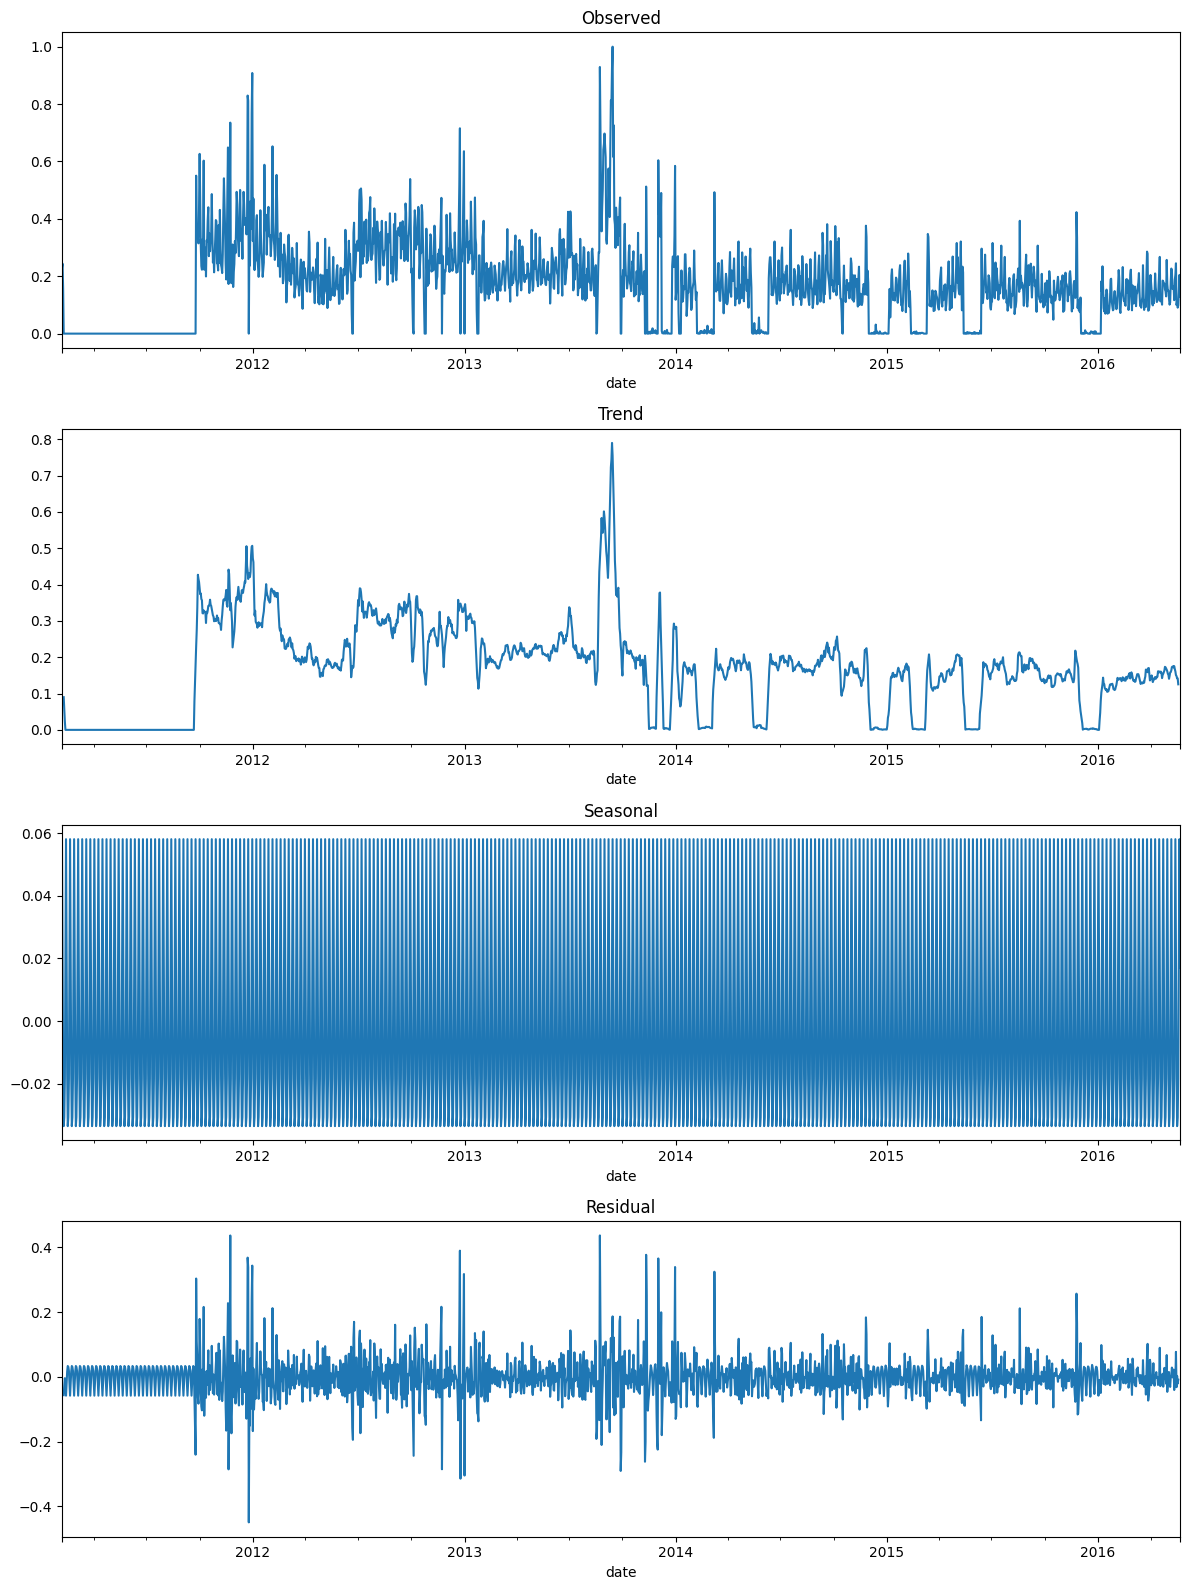

ADF Statistic: -4.227336106736274
p-value: 0.0005921063508314376
Critical Values: {'1%': -3.4337801282776335, '5%': -2.8630552063395585, '10%': -2.5675766377428086}


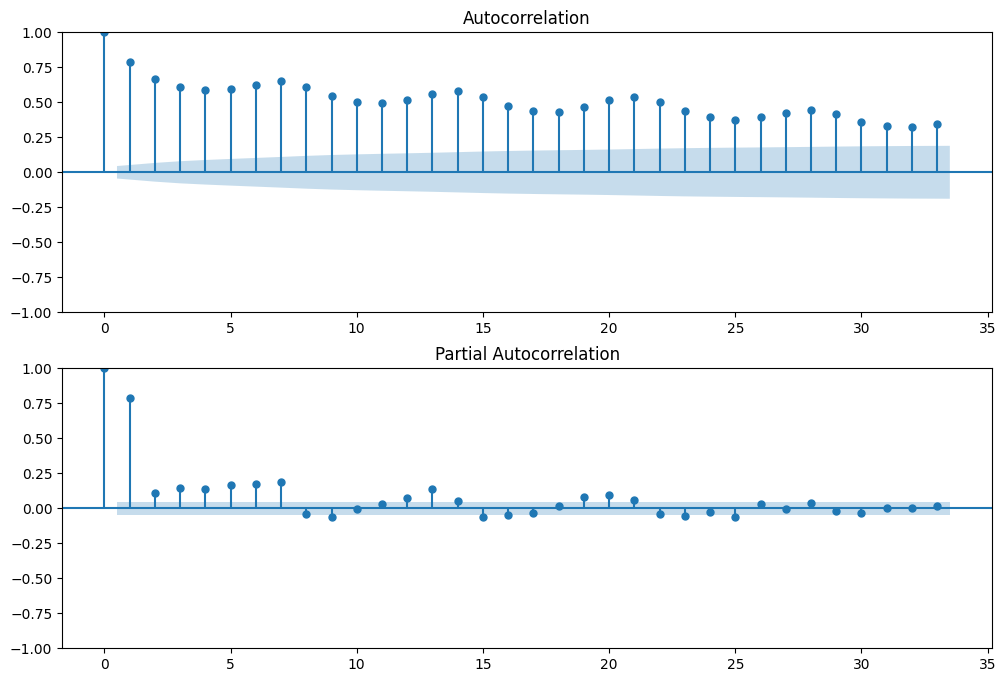

In [13]:
def analyze_time_series(data):
    # Decompose the time series
    decomposition = seasonal_decompose(data, model='additive')
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()
    
    # Perform ADF test
    result = adfuller(data.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data, ax=ax1)
    plot_pacf(data, ax=ax2)
    plt.show()

# Usage
analyze_time_series(sales_data)

## LSTM

LSTM training completed in: 0.53 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━

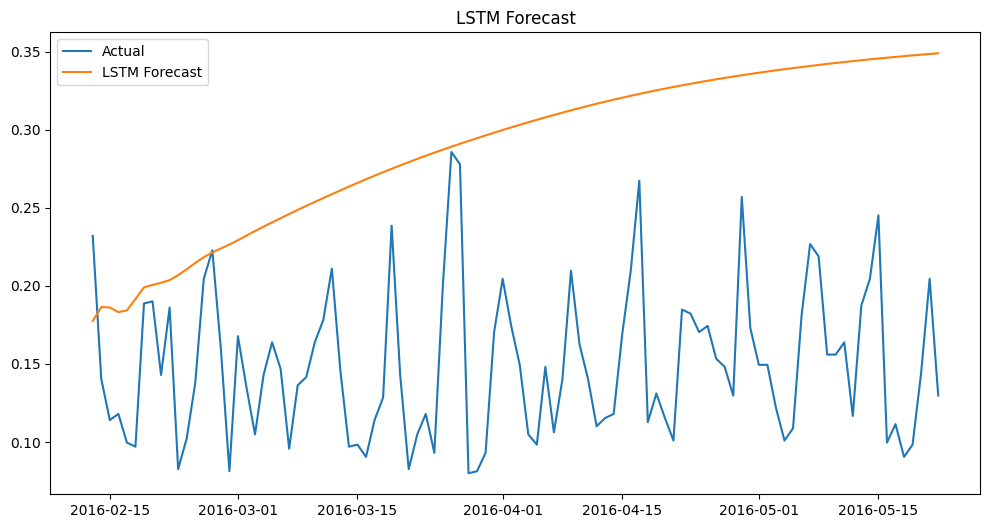

In [14]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sales_data.values.reshape(-1, 1))

seq_length = 12
x_train, y_train = create_sequences(scaled_data[:-100], seq_length)
x_test, y_test = create_sequences(scaled_data[-100-seq_length:], seq_length)

# Train LSTM model
start_time = time.time()
lstm_model = create_lstm_model((seq_length, 1))
lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
duration = (time.time() - start_time) / 60
print(f'LSTM training completed in: {duration:.2f} minutes')

# Forecast using LSTM
lstm_forecast = []
last_sequence = x_test[0]
for _ in range(100):
    next_pred = lstm_model.predict(last_sequence.reshape(1, seq_length, 1))[0, 0]
    lstm_forecast.append(next_pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(test_sarima, lstm_forecast))
print(f'LSTM RMSE: {lstm_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual')
plt.plot(test_sarima.index, lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

## PROPHET

10:27:34 - cmdstanpy - INFO - Chain [1] start processing
10:27:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet training completed in: 0.01 minutes
Prophet RMSE: 0.11


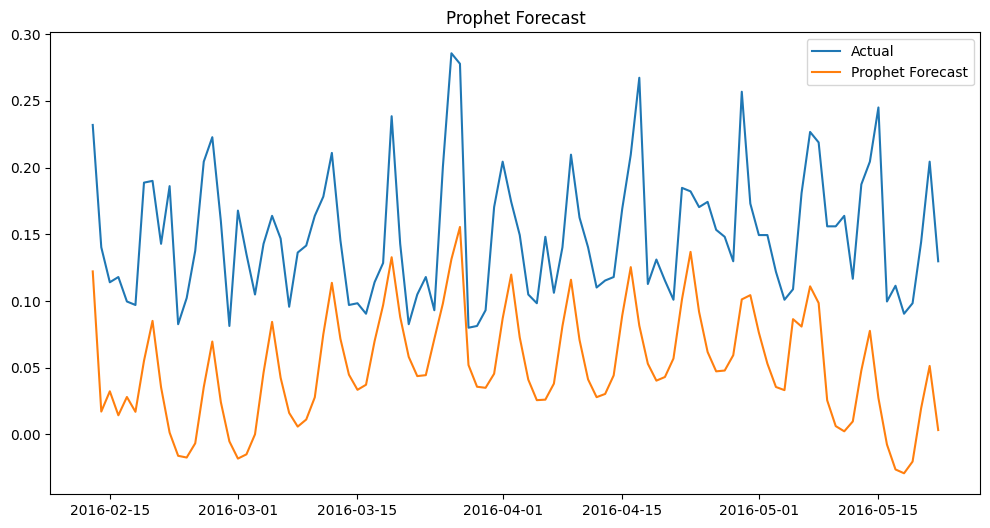

In [15]:
def prepare_prophet_data(data, calendar):
    prophet_data = pd.DataFrame({'ds': data.index, 'y': data.values})
    holidays = calendar[calendar['event_type_1'].notnull()][['date', 'event_name_1']]
    holidays.columns = ['ds', 'holiday']
    holidays['ds'] = pd.to_datetime(holidays['ds'])
    return prophet_data, holidays

def fit_prophet_model(data, holidays):
    model = prophet.Prophet(holidays=holidays, weekly_seasonality=True)
    model.fit(data)
    return model

def forecast_prophet(model, periods):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Prepare data for Prophet
prophet_data, holidays = prepare_prophet_data(sales_data, calendar)
train_prophet = prophet_data[:-100]
test_prophet = prophet_data[-100:]

# Train Prophet model
start_time = time.time()
prophet_model = fit_prophet_model(train_prophet, holidays)
duration = (time.time() - start_time) / 60
print(f'Prophet training completed in: {duration:.2f} minutes')

# Forecast using Prophet
prophet_forecast = forecast_prophet(prophet_model, periods=100)
prophet_forecast = prophet_forecast.iloc[-100:]['yhat']

# Calculate RMSE
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))
print(f'Prophet RMSE: {prophet_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual')
plt.plot(test_prophet['ds'], prophet_forecast, label='Prophet Forecast')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

SARIMA training completed in: 5.34 minutes
SARIMA RMSE: 0.04


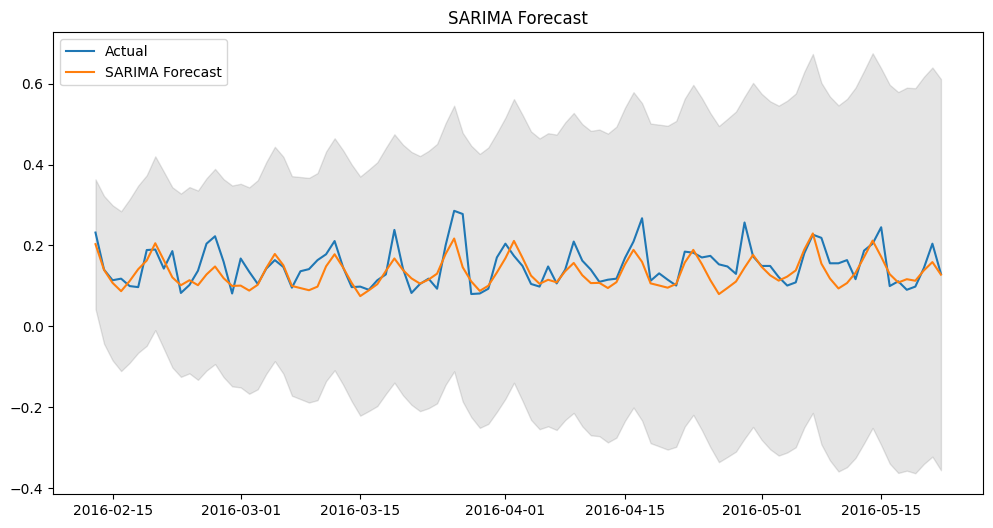

In [19]:
def fit_sarima_model(train, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return results

def forecast_sarima(model, steps):
    forecast = model.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

# Usage
sales_data = pd.to_numeric(sales_data, errors='coerce')

train_sarima = sales_data[:-100]
test_sarima = sales_data[-100:]

# train_sarima = pd.to_numeric(sales_data, errors='coerce')
# test_sarima = pd.to_numeric(sales_data, errors='coerce')

start_time = time.time()
sarima_model = fit_sarima_model(train_sarima, order=(2, 1, 1), seasonal_order=(2, 1, 1, 42))
duration = (time.time() - start_time) / 60
print(f'SARIMA training completed in: {duration:.2f} minutes')

sarima_forecast, sarima_conf_int = forecast_sarima(sarima_model, steps=100)

# Calculate RMSE
sarima_rmse = np.sqrt(mean_squared_error(test_sarima, sarima_forecast))
print(f'SARIMA RMSE: {sarima_rmse:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, test_sarima, label='Actual')
plt.plot(test_sarima.index, sarima_forecast, label='SARIMA Forecast')
plt.fill_between(test_sarima.index, sarima_conf_int.iloc[:, 0], sarima_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

## MODEL COMPARISION

SARIMA RMSE: 0.04
LSTM RMSE: 0.15
Prophet RMSE: 0.11


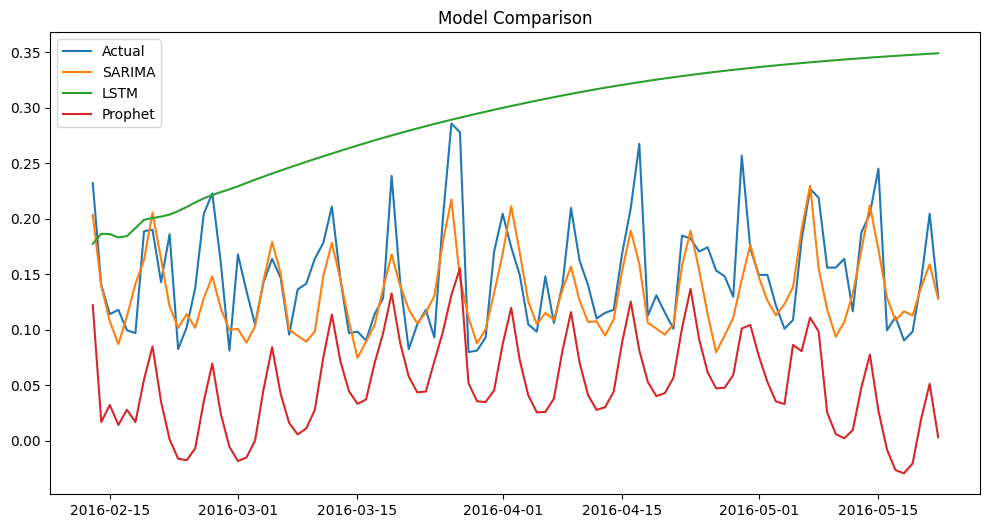

In [20]:
def compare_models(actual, sarima_forecast, lstm_forecast, prophet_forecast):
    sarima_rmse = np.sqrt(mean_squared_error(actual, sarima_forecast))
    lstm_rmse = np.sqrt(mean_squared_error(actual, lstm_forecast))
    prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_forecast))
    
    print(f'SARIMA RMSE: {sarima_rmse:.2f}')
    print(f'LSTM RMSE: {lstm_rmse:.2f}')
    print(f'Prophet RMSE: {prophet_rmse:.2f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, sarima_forecast, label='SARIMA')
    plt.plot(actual.index, lstm_forecast, label='LSTM')
    plt.plot(actual.index, prophet_forecast, label='Prophet')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

# Usage
compare_models(test_sarima,sarima_forecast, lstm_forecast, prophet_forecast)